# Predict box office revenue of movies

## Goal:
 Predict the revenue of a movie based on information which is available before the movie is released
## Process:
1. Get data from the database
 2. Check for missing values/Clean Data
3. Create new features
4. Normalize/Standardize Data
5. Train different models + optimize hyperparameters
6. Evaluate the models (loss, Score, SHAP)
7. Save the best model
## Result:
 The best model is a MLPRegressor with a mean squared error of 0.00019. Only about 5000 movies suit the criteria (over 26.000 in database).

## Improvements:
- Get missing values from Imdb/wikipedia
- Improve prediction with other features

In [1]:
# Import all necessary libraries
import os
import psycopg2
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

In [21]:
# Set global settings

save_models = True
plot_feature_distribution_for_training = False
search_for_best_hyperparameters = False
save_shape_plot = True

In [2]:
%env POSTGRES_PASSWORD=9YBhSoDiMhwFjhC892BcaVkFv5mdP8qFwM5Lv9jPwqekRWKLXEKF5Fjr9zCyKsMgVeXpUxbobMZJRth3GeUuPdbD2XiicCnTcNeFscJchuaEVaMDXMxZ8zJkoG9QMQjy

env: POSTGRES_PASSWORD=9YBhSoDiMhwFjhC892BcaVkFv5mdP8qFwM5Lv9jPwqekRWKLXEKF5Fjr9zCyKsMgVeXpUxbobMZJRth3GeUuPdbD2XiicCnTcNeFscJchuaEVaMDXMxZ8zJkoG9QMQjy


# Get data and explore it

In [3]:
# Database connection parameters
db_params = {
    'dbname': 'movie_db', 
    'user': 'postgres', 
    'password': os.environ['POSTGRES_PASSWORD'], 
    'host': '49.13.1.33',
    'port': '5333'
}

# Connection
conn = psycopg2.connect(**db_params)

# Helper function to query the database
def query_db(sql_query, conn):
    return pd.read_sql_query(sql_query, conn)

In [4]:
movies = query_db("""
SELECT * FROM Movies
""", conn)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [5]:
# Print how many movies are in the database
print(f"There are {len(movies)} movies in the database.")
# Print how many movies don't have a budget or have 0 as a budget
print(f"There are {len(movies[movies['budget'].isna()])} movies without a budget.")
print(f"There are {len(movies[movies['budget'] == 0])} movies with 0 as a budget.")

There are 715723 movies in the database.
There are 0 movies without a budget.
There are 678886 movies with 0 as a budget.


In [6]:
# TODO: Don't throw away movies without a budget/revenue --> get from Imdb
movies = query_db("""
SELECT 
    m.id,
    m.budget,
    m.runtime,
    m.original_language,
    m.revenue,
    m.title,
    m.adult,
    STRING_AGG(g.name, ', ') AS genres,
    STRING_AGG(pc.name, ', ') AS production_companies,
    STRING_AGG(DISTINCT mpc2.iso_3166_1, ', ') AS production_countries
FROM 
    Movies m
LEFT JOIN 
    MovieGenres mg ON m.id = mg.movie_id
LEFT JOIN 
    Genres g ON mg.genre_id = g.id
LEFT JOIN 
    MovieProductionCompanies mpc ON m.id = mpc.movie_id
LEFT JOIN 
    ProductionCompanies pc ON mpc.production_company_id = pc.id
LEFT JOIN
    MovieProductionCountries mpc2 ON m.id = mpc2.movie_id
WHERE m.budget > 0 AND m.revenue > 0 AND pc.name IS NOT NULL AND g.name IS NOT NULL AND m.runtime > 0 AND mpc2.iso_3166_1 IS NOT NULL
GROUP BY 
    m.id
""", conn)

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [8]:
movies.head()

,id,budget,runtime,original_language,revenue,title,adult,genres,production_companies,production_countries
0,5,4000000.0,98,en,4257354.0,Four Rooms,False,"Comedy, Comedy","Miramax, A Band Apart",US
1,6,21000000.0,109,en,12136938.0,Judgment Night,False,"Action, Thriller, Crime, Action, Thriller, Crime","JVC, JVC, JVC, LARGO Entertainment, LARGO Ente...",US
2,11,11000000.0,121,en,775398007.0,Star Wars,False,"Science Fiction, Adventure, Action, Science Fi...","20th Century Fox, Lucasfilm Ltd., Lucasfilm Lt...",US
3,12,94000000.0,100,en,940335536.0,Finding Nemo,False,"Family, Animation","Pixar, Pixar",US
4,13,55000000.0,142,en,677387716.0,Forrest Gump,False,"Comedy, Drama, Romance, Comedy, Drama, Romance...","Paramount, The Steve Tisch Company, Wendy Fine...",US




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='production_countries', ylabel='Density'>

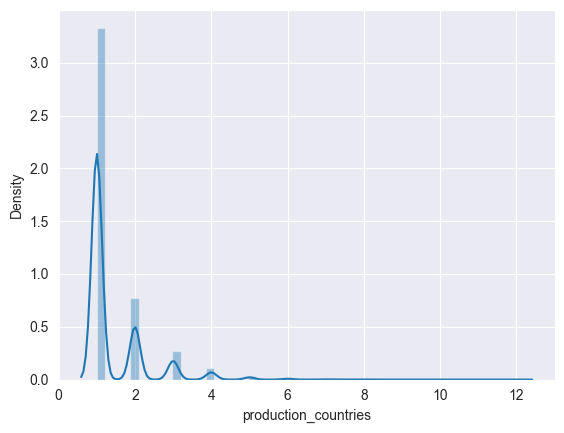

In [9]:
# Print the distribution of number of production countries
sns.distplot(movies['production_countries'].apply(lambda x: len(x.split(", "))))

In [10]:
# Print how many movies are in the database
print(f"There are {len(movies)} movies in the database.")
# Print how many movies don't have a budget or have 0 as a budget
print(f"There are {len(movies[movies['budget'].isna()])} movies without a budget.")
print(f"There are {len(movies[movies['budget'] == 0])} movies with 0 as a budget.")

There are 9581 movies in the database.
There are 0 movies without a budget.
There are 0 movies with 0 as a budget.


In [11]:
movies.describe()
movies.any().isna()

id                      False
budget                  False
runtime                 False
original_language       False
revenue                 False
title                   False
adult                   False
genres                  False
production_companies    False
production_countries    False
dtype: bool

In [12]:
# Print unique values for original_language
print(movies['original_language'].unique())
print(len(movies['original_language'].unique()))

['en' 'de' 'he' 'es' 'zh' 'ja' 'da' 'fr' 'it' 'sv' 'pt' 'ko' 'cs' 'cn'
 'tn' 'fi' 'ru' 'ro' 'tr' 'hi' 'pl' 'hu' 'nl' 'th' 'el' 'ta' 'iu' 'no'
 'fa' 'vi' 'et' 'ml' 'ms' 'te' 'ar' 'nb' 'gl' 'tl' 'sr' 'ca' 'bm' 'id'
 'pa' 'hr' 'xx' 'ku' 'ur' 'bn' 'kn' 'uk' 'mr' 'dv' 'sq' 'bs' 'ne' 'ht'
 'si' 'lv' 'dz' 'az' 'lt' 'la' 'lg' 'km' 'gu' 'ab' 'sk' 'am']
68


In [13]:
# Find all genres and count the occurrences
genres = [genre for sublist in movies['genres'].str.split(', ') for genre in set(sublist)]
genre_counts = Counter(genres)

sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
for genre, count in sorted_genres:
    print(f"{genre}: {count}")

print(set(genres))
print(len(genres))

Drama: 4497
Comedy: 3418
Action: 2339
Thriller: 2293
Romance: 1803
Adventure: 1593
Crime: 1448
Horror: 1115
Science Fiction: 961
Family: 954
Fantasy: 925
Mystery: 816
Animation: 549
History: 476
Music: 380
War: 350
Documentary: 180
Western: 159
TV Movie: 22
{'Mystery', 'Fantasy', 'Family', 'Crime', 'Adventure', 'Animation', 'War', 'Documentary', 'Action', 'Comedy', 'Horror', 'Romance', 'Thriller', 'Science Fiction', 'History', 'Music', 'Drama', 'TV Movie', 'Western'}
24278


In [14]:
# Find all production companies and count the occurrences
production_companies = [company for sublist in movies['production_companies'].str.split(', ') for company in set(sublist)]
company_counts = Counter(production_companies)

sorted_companies = sorted(company_counts.items(), key=lambda x: x[1], reverse=True)

print(set(production_companies))
print(len(production_companies))

{'Noelle Entertainment Limited', 'BillBlock Media', 'Samuel Hadida Presents', 'Virgin', 'Latent Image Productions Pty. Ltd.', 'American Hero Films', 'Panasonic Corporation', 'Skate Away Productions', 'Santa Claus Ltd.', 'Haut et Court', 'Yong Film', 'Èliseo Entertainment', 'Cataland Films', 'Navneet Productions', 'Toron Screen Corporation', 'Fairview Productions', 'Chad Troutwine Films', 'Off White Productions Inc.', 'Star Partners', 'Pathé Consortium Cinéma', 'Heritage Films', 'Terra Firma Films', 'Deux Chevaux Films', 'Bohemian Garden', 'Dee Gee Entertainment', 'Showbox', 'Caroline Films', 'Legendary East', 'Couchman Productions', 'Universe Entertainment Limited', 'Reliance Entertainment', 'Paradox Entertainment', 'Gran Via Productions', 'Firelight Films', 'Almost Never Films', 'uFund', 'Summa Entertainment Group', 'Vlaanderen in Actie', 'Fitch', 'Corazon Hayagriva', 'Interesting Human Media', 'OC Film', 'Metamora Films', 'Avalon Pictures', 'Tin Toy Productions LLC', 'Salman Khan Fil

# Create new features from existing data

In [15]:
# For every film check whether it is in the top 100 production companies
top_100_companies = [company for company, count in sorted_companies[:100]]
movies['top_100_company'] = movies['production_companies'].apply(lambda x: any([company in x.split(", ") for company in top_100_companies]))

# For every film check whether it is in the top 5 genres
top_5_genres = [genre for genre, count in sorted_genres[:5]]
movies['top_5_genre'] = movies['genres'].apply(lambda x: any([genre in x.split(", ") for genre in top_5_genres]))


# Create two boolean features for if the production country is US and if it is UK
# (while exploring features these two countries had the most influence on the revenue)
movies['production_country_is_us'] = movies['production_countries'].apply(lambda x: 1 if 'US' in x.split(", ") else 0)
movies['production_country_is_uk'] = movies['production_countries'].apply(lambda x: 1 if 'UK' in x.split(", ") else 0)

movies.head()

,id,budget,runtime,original_language,revenue,title,adult,genres,production_companies,production_countries,top_100_company,top_5_genre,production_country_is_us,production_country_is_uk
0,5,4000000.0,98,en,4257354.0,Four Rooms,False,"Comedy, Comedy","Miramax, A Band Apart",US,True,True,1,0
1,6,21000000.0,109,en,12136938.0,Judgment Night,False,"Action, Thriller, Crime, Action, Thriller, Crime","JVC, JVC, JVC, LARGO Entertainment, LARGO Ente...",US,False,True,1,0
2,11,11000000.0,121,en,775398007.0,Star Wars,False,"Science Fiction, Adventure, Action, Science Fi...","20th Century Fox, Lucasfilm Ltd., Lucasfilm Lt...",US,True,True,1,0
3,12,94000000.0,100,en,940335536.0,Finding Nemo,False,"Family, Animation","Pixar, Pixar",US,True,False,1,0
4,13,55000000.0,142,en,677387716.0,Forrest Gump,False,"Comedy, Drama, Romance, Comedy, Drama, Romance...","Paramount, The Steve Tisch Company, Wendy Fine...",US,True,True,1,0


## Other features tried but not used:

### Number of production companies
```python
movies['number_of_production_companies'] = movies['production_companies'].apply(lambda x: len(x.split(", ")))
```

### Length of the title
```python
#movies['title_length'] = movies['title'].apply(lambda x: len(x))
```
### Budget divided by number of production companies
```python
# Create new helpful features budget divided by number of production companies
#movies['budget_to_production_companies'] = movies['budget'] / movies['production_companies'].apply(lambda x: len(x.split(", ")))
```
### Budget divided by runtime
```python
# Create new helpful feature budget divided by runtime
#movies['budget_to_runtime'] = movies['budget'] / movies['runtime']
```

### Budget divided by number of genres
```python
# Splitting the production_countries column into separate rows for each country
#ovies = movies.assign(production_countries=movies['production_countries'].str.split(', ')).explode('production_countries')
```
### One-hot encoding for the production_countries
```python
# Creating one-hot encoding for the production_countries
#ovies = pd.get_dummies(movies,columns=['production_countries'], prefix='country')
```

In [16]:
# See how many movies are in the top 100 production companies
movies['top_100_company'].value_counts()

top_100_company
True     5821
False    3760
Name: count, dtype: int64

In [17]:
# One Hot encode the original_language column and genres column
movies = pd.get_dummies(movies, columns=['original_language'])

## Other one-hot encodings tried but not used:

### Split genres and take the first one as the genre
```python
#movies['genres'] = movies['genres'].apply(lambda x: x.split(", ")[0])
```
### One-hot encoding for the genres
```python
#movies = pd.get_dummies(movies, columns=['genres'])
```
### One-hot encoding for the production_companies
```python
# Only set bool if language is english
#movies['original_language'] = movies['original_language'].apply(lambda x: 1 if x == 'en' else 0)
```


In [18]:
movies.head()

,id,budget,runtime,revenue,title,adult,genres,production_companies,production_countries,top_100_company,...,original_language_te,original_language_th,original_language_tl,original_language_tn,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_xx,original_language_zh
0,5,4000000.0,98,4257354.0,Four Rooms,False,"Comedy, Comedy","Miramax, A Band Apart",US,True,...,False,False,False,False,False,False,False,False,False,False
1,6,21000000.0,109,12136938.0,Judgment Night,False,"Action, Thriller, Crime, Action, Thriller, Crime","JVC, JVC, JVC, LARGO Entertainment, LARGO Ente...",US,False,...,False,False,False,False,False,False,False,False,False,False
2,11,11000000.0,121,775398007.0,Star Wars,False,"Science Fiction, Adventure, Action, Science Fi...","20th Century Fox, Lucasfilm Ltd., Lucasfilm Lt...",US,True,...,False,False,False,False,False,False,False,False,False,False
3,12,94000000.0,100,940335536.0,Finding Nemo,False,"Family, Animation","Pixar, Pixar",US,True,...,False,False,False,False,False,False,False,False,False,False
4,13,55000000.0,142,677387716.0,Forrest Gump,False,"Comedy, Drama, Romance, Comedy, Drama, Romance...","Paramount, The Steve Tisch Company, Wendy Fine...",US,True,...,False,False,False,False,False,False,False,False,False,False


In [19]:
# Drop unnecessary columns
movies.drop(['id', 'production_companies', 'title', 'genres', 'adult', 'production_countries'], axis=1, inplace=True)

movies.head()

,budget,runtime,revenue,top_100_company,top_5_genre,production_country_is_us,production_country_is_uk,original_language_ab,original_language_am,original_language_ar,...,original_language_te,original_language_th,original_language_tl,original_language_tn,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_xx,original_language_zh
0,4000000.0,98,4257354.0,True,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,21000000.0,109,12136938.0,False,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,11000000.0,121,775398007.0,True,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,94000000.0,100,940335536.0,True,False,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,55000000.0,142,677387716.0,True,True,1,0,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Normalize/Standardize Data for better performance

In [22]:
# Selecting the columns for normalization and standardization
columns_to_scale = [ 'runtime', 'budget'] 
target_column = 'revenue'

# Creating scaler
min_max_scaler = MinMaxScaler()

# Applying Min-Max Normalization
normalized_data = min_max_scaler.fit_transform(movies[columns_to_scale])
normalized_df = pd.DataFrame(normalized_data, columns=columns_to_scale)
normalized_df.head()

# Normalize the target column
movies[target_column] = min_max_scaler.fit_transform(movies[[target_column]])

# Save the scaler for later use
if save_models:
    with open('min_max_scaler.pkl', 'wb') as f:
        pickle.dump(min_max_scaler, f)

In [23]:
# Merge dataframes
movies[columns_to_scale] = normalized_df

In [24]:
# Extract target column
target = movies['revenue']
movies.drop(['revenue'], axis=1, inplace=True)
movies.head()

,budget,runtime,top_100_company,top_5_genre,production_country_is_us,production_country_is_uk,original_language_ab,original_language_am,original_language_ar,original_language_az,...,original_language_te,original_language_th,original_language_tl,original_language_tn,original_language_tr,original_language_uk,original_language_ur,original_language_vi,original_language_xx,original_language_zh
0,0.008696,0.286982,True,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,0.045652,0.319527,False,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,0.023913,0.355030,True,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0.204348,0.292899,True,False,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,0.119565,0.417160,True,True,1,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
# Print distribution of every feature
if plot_feature_distribution_for_training:
    for column in movies.columns:
        if column.startswith('original_language'):
            continue
        sns.distplot(movies[column]) 
        plt.show()

# Create train and test set

In [26]:
# Split in train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(movies, target, test_size=0.2, random_state=42)

# Experiment with different models

In [27]:
# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)

# Evaluate the model
y_pred = linear_regression.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score: {linear_regression.score(X_test, y_test)}")

Mean squared error: 1.569572934762062e+18
Model Score: -5.527232710788135e+20


Mean squared error: 0.0016428444221478892
Model Score: 0.42147426043580594


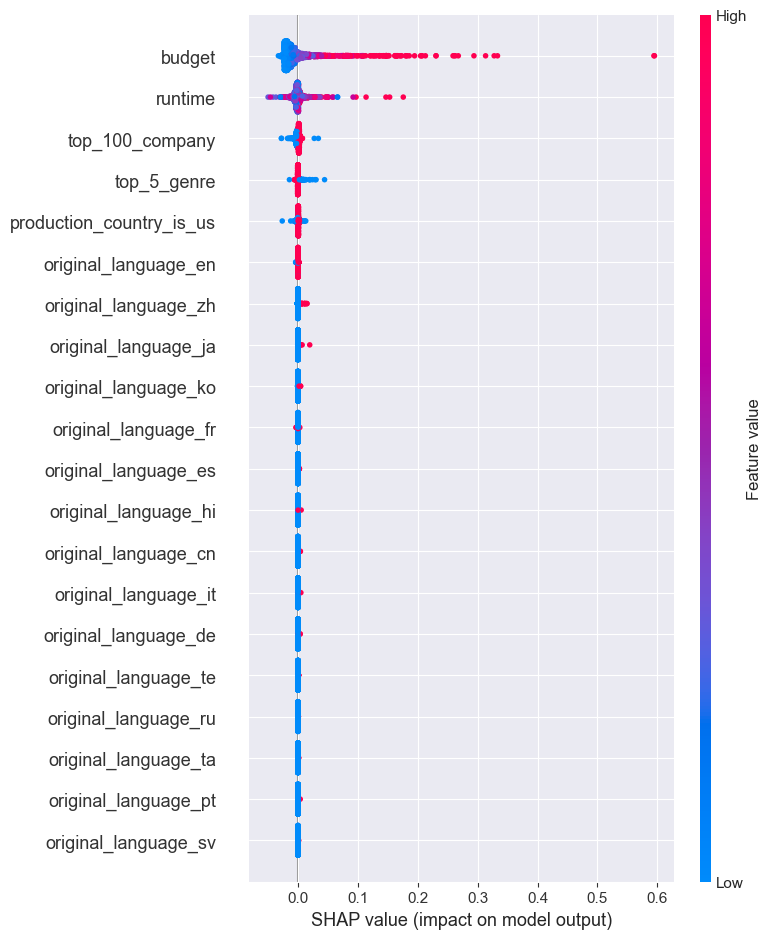

In [28]:
# Random Forest
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
# Evaluate the model
y_pred = random_forest.predict(X_test)

print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score: {random_forest.score(X_test, y_test)}")

explainer = shap.TreeExplainer(random_forest)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_random_forest.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)

Mean squared error initial model: 0.0012496246585282963
Model Score initial model: 0.5599461397522054


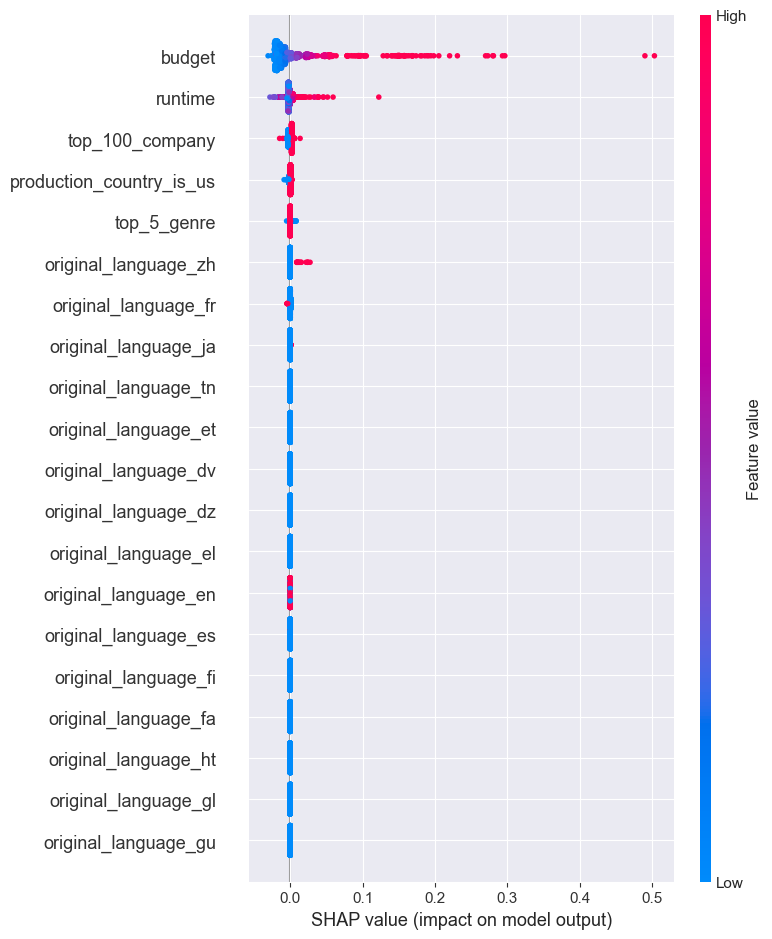

In [30]:
# Gradient Boosting
gradient_boosting = GradientBoostingRegressor()
gradient_boosting.fit(X_train, y_train)
# Evaluate the model
y_pred = gradient_boosting.predict(X_test)

print(f"Mean squared error initial model: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score initial model: {gradient_boosting.score(X_test, y_test)}")

# Hyperparameter tuning
if search_for_best_hyperparameters:
    
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 1]
    }
    
    grid_search = GridSearchCV(GradientBoostingRegressor(), param_grid, cv=5, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")

    # Use best parameters
    gradient_boosting = GradientBoostingRegressor(**grid_search.best_params_)
    gradient_boosting.fit(X_train, y_train)
    # Evaluate the model
    y_pred = gradient_boosting.predict(X_test)
    
    print(f"Mean squared error of fine-tuned model: {mean_squared_error(y_test, y_pred)}")
    print(f"Model Score of fine-tuned model: {gradient_boosting.score(X_test, y_test)}")

# Use SHAP to explain the predictions
explainer = shap.TreeExplainer(gradient_boosting)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_gradient_boosting.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)

In [31]:
# Simple Neural Network
mlp = MLPRegressor()
mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)

print(f"Mean squared error of simple model: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score of simple model: {mlp.score(X_test, y_test)}")

# Extract the original values from the normalized values
original_values = min_max_scaler.inverse_transform(y_pred.reshape(-1, 1))

Mean squared error of simple model: 0.0013287478441956918
Model Score of simple model: 0.5320830025690398




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



Mean difference: 0.007985515917249952


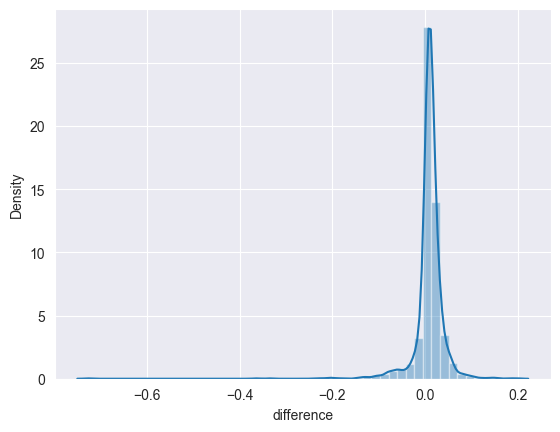

In [32]:
# Create a dataframe with the predictions and the actual values
predictions_df = pd.DataFrame({
    'predicted_revenue': original_values.reshape(-1),
    'actual_revenue': min_max_scaler.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)
})

# Calculate the difference between the predicted and the actual revenue
predictions_df['difference'] = predictions_df['predicted_revenue'] - predictions_df['actual_revenue']

# Plot the difference
sns.distplot(predictions_df['difference'])

# Print the mean difference
print(f"Mean difference: {predictions_df['difference'].mean()}")

# Save model
if save_models:
    with open('mlp_model_small.pkl', 'wb') as f:
        pickle.dump(mlp, f)

In [33]:
# This may take a long time
if search_for_best_hyperparameters:
    # Use GridSearchCV to find the best parameters
    from sklearn.model_selection import GridSearchCV
    
    param_grid = {
        'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
        'activation': ['relu', 'tanh', 'logistic'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'learning_rate_init': [0.001, 0.01, 0.1],
        'max_iter': [100, 200, 300],
        'early_stopping': [True, False],
        'warm_start': [True, False],
        'alpha': [0.0001, 0.001, 0.01]
    }
    
    grid_search = GridSearchCV(MLPRegressor(), param_grid, cv=5, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")

Mean squared error of fine-tuned model: 0.0012394147624933067
Model Score of fine-tuend model: 0.5635415426856089
Mean difference of fine-tuned model: -0.001690522997592047




`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



  0%|          | 0/1917 [00:00<?, ?it/s]

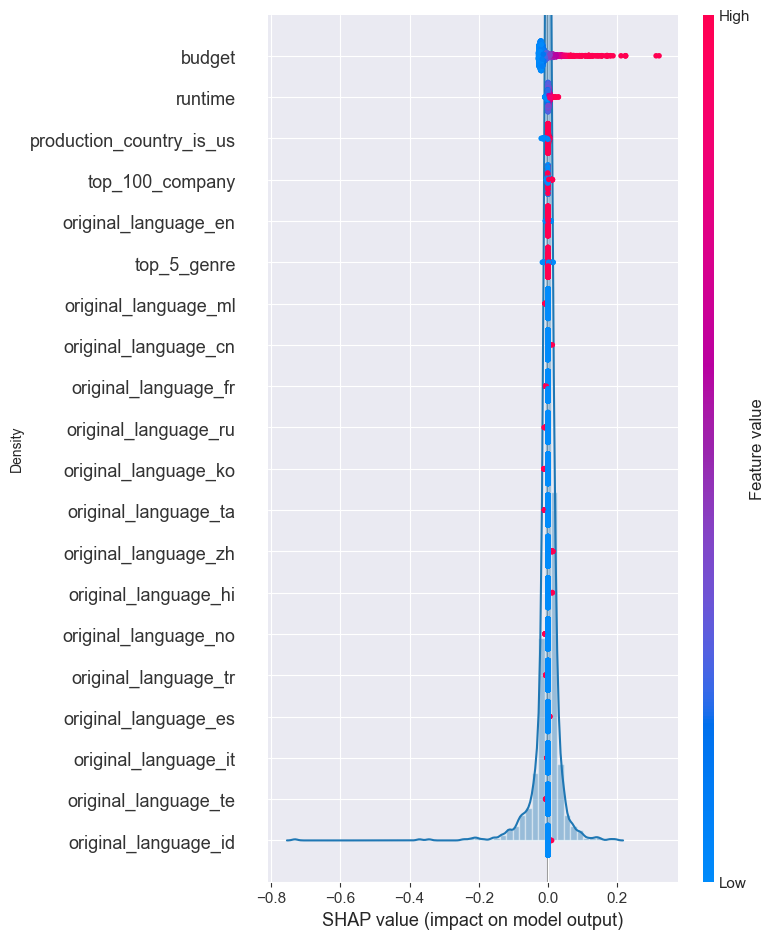

In [34]:
# Use best parameters
best_params = grid_search.best_params_ if search_for_best_hyperparameters else {'activation': 'relu', 'alpha': 0.01, 'early_stopping': True, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'max_iter': 100, 'warm_start': False}


mlp = MLPRegressor(**best_params)
mlp.fit(X_train, y_train)

# Evaluate the model
y_pred = mlp.predict(X_test)

print(f"Mean squared error of fine-tuned model: {mean_squared_error(y_test, y_pred)}")
print(f"Model Score of fine-tuend model: {mlp.score(X_test, y_test)}")
original_values = min_max_scaler.inverse_transform(y_pred.reshape(-1, 1))

# Create a dataframe with the predictions and the actual values
predictions_df = pd.DataFrame({
    'predicted_revenue': original_values.reshape(-1),
    'actual_revenue': min_max_scaler.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)
})

predictions_df['difference'] = predictions_df['predicted_revenue'] - predictions_df['actual_revenue']

# Plot the difference
sns.distplot(predictions_df['difference'])

# Print the mean difference
print(f"Mean difference of fine-tuned model: {predictions_df['difference'].mean()}")

if save_models:
    with open('mlp_model_fine_tuned.pkl', 'wb') as f:
        pickle.dump(mlp, f)
        

K = 20 # To speed up the computation, we will use only a small amount of training examples in our background
background_data_summary = shap.sample(X_train, K)

explainer = shap.KernelExplainer(mlp.predict, background_data_summary)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_mlp.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)

In [35]:
# Have a look at the predictions
predictions_df.describe()

,predicted_revenue,actual_revenue,difference
count,1917.000000,1917.000000,1917.000000
mean,0.021224,0.022914,-0.001691
std,0.038630,0.053303,0.035174
min,-0.015711,0.000000,-0.730848
25%,0.001421,0.000718,-0.005008
50%,0.007836,0.004446,0.000234
75%,0.022998,0.020959,0.007281
max,0.375140,1.000000,0.193573


2023-12-11 21:59:43.886365: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2023-12-11 21:59:43.886393: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2023-12-11 21:59:43.886396: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2023-12-11 21:59:43.886447: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-11 21:59:43.886479: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               7500      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

2023-12-11 21:59:44.714483: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-12-11 21:59:44.733906: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


24/24 [==============================] - 2s 17ms/step - loss: 0.0403 - mse: 0.0403 - val_loss: 0.0032 - val_mse: 0.0032
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0236 - mse: 0.0236 - val_loss: 0.0030 - val_mse: 0.0030
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0161 - mse: 0.0161 - val_loss: 0.0028 - val_mse: 0.0028
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0125 - mse: 0.0125 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0094 - mse: 0.0094 - val_loss: 0.0024 - val_mse: 0.0024
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0083 - mse: 0.0083 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 0.0080 - mse: 0.0080 



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.


  0%|          | 0/1917 [00:00<?, ?it/s]

159/159 [==============================] - 0s 1ms/step


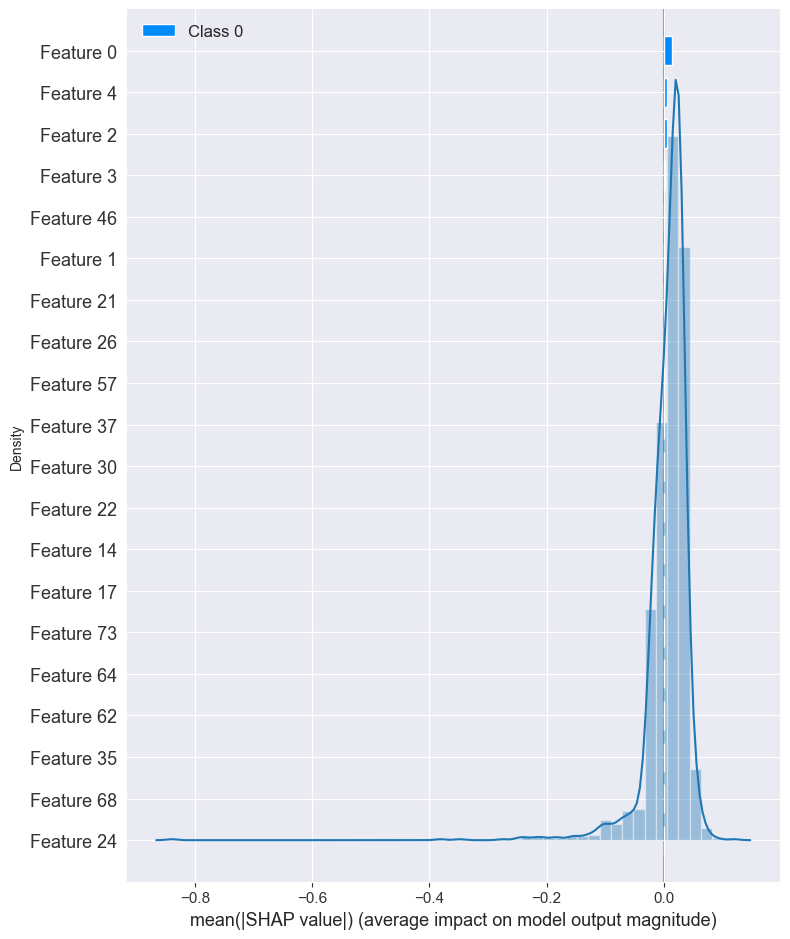

In [36]:
# Use Keras to create a neural network
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mse'])

model.summary()

model.fit(X_train, y_train, epochs=100, batch_size=256, validation_split=0.2)

y_pred = model.predict(X_test)

print(f"Mean squared error of keras model: {mean_squared_error(y_test, y_pred)}")

# Evaluate the model
y_pred = model.predict(X_test)

print(f"Mean squared error of keras model: {mean_squared_error(y_test, y_pred)}")

original_values = min_max_scaler.inverse_transform(y_pred.reshape(-1, 1))

# Create a dataframe with the predictions and the actual values
predictions_df = pd.DataFrame({
    'predicted_revenue': original_values.reshape(-1),
    'actual_revenue': min_max_scaler.inverse_transform(y_test.values.reshape(-1, 1)).reshape(-1)
})

predictions_df['difference'] = predictions_df['predicted_revenue'] - predictions_df['actual_revenue']

# Plot the difference
sns.distplot(predictions_df['difference'])

print(f"Mean difference of keras model: {predictions_df['difference'].mean()}")

# Save model
if save_models:
    model.save('keras_model.h5')

# SHAP values
background_data_summary = shap.sample(X_train, K)
explainer = shap.KernelExplainer(model.predict, background_data_summary)
shap_values = explainer.shap_values(X_test)

plt.savefig('models/shap/shap_keras.png') if save_shape_plot else None
shap.summary_plot(shap_values, X_test)